In [ ]:
#1-3 simple.py
import tensorflow as tf

# You can create constants in TF to
# hold specific values
a = tf.constant(1)
b = tf.constant(2)

# Of course you can add, multiply,
# and compute on these as you like
c = a + b
d = a * b

# TF numbers are stored in "tensors",
# a fancy term for multidimensional arrays
# If you pass TF a Python list, it can convert it
V1 = tf.constant([1., 2.])   # Vector, 1-dimensional
V2 = tf.constant([3., 4.])   # Vector, 1-dimensional
M = tf.constant([[1., 2.]])             # Matrix, 2d
N = tf.constant([[1., 2.],[3.,4.]])     # Matrix, 2d
K = tf.constant([[[1., 2.],[3.,4.]]])   # Tensor, 3d+

# You can also compute on tensors
# like you did scalars, but be careful of shape
V3 = V1 + V2

# Operations are element-wise by default
M2 = M * M

# True matrix multiplication requires a special call
NN = tf.matmul(N,N)

# The above code only defines a TF "graph".
# Nothing has been computed yet
# For that, you first need to create a TF "session"
sess = tf.Session()
# Note the parallelism information TF
# reports to you when starting a session

# Now you can run specific nodes of your graph,
# i.e. the variables you've named
output = sess.run(NN)
print("NN is:")
print(output)

# Remember to close your session
# when you're done using it
sess.close()

# Often, we work interactively,
# it's convenient to use a simplified session
sess = tf.InteractiveSession()

# Now we can compute any node
print("M2 is:")
print(M2.eval())

# TF "variables" can change value,
# useful for updating model weights
W = tf.Variable(0, name="weight")

# But variables must be initialized by TF before use
init_op = tf.initialize_all_variables()
sess.run(init_op)

print("W is:")
print(W.eval())

W += a
print("W after adding a:")
print(W.eval())

W += a
print("W after adding a again:")
print(W.eval())

# You can return or supply arbitrary nodes,
# i.e. check an intermediate value or
# sub your value in the middle of a computation

E = d + b # 1*2 + 2 = 4

print("E as defined:")
print(E.eval())

# Let's see what d was at the same time
print("E and d:")
print(sess.run([E,d]))

# Use a custom d by specifying a dictionary
print("E with custom d=4:")
print(sess.run(E, feed_dict = {d:4.}))


In [ ]:
#1-4 logistic.py
import tensorflow as tf
import numpy as np
#%autoindent
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# Load data
# (..) data = np.load('data_with_labels.npz')
data = np.load('/Users/Gene/Google Drive/UCI2016Winter/274C NRL NTWKS&DEEP LRNG Lec A /Project/Gene-Git/stock-prediction/Udemy-Tensorflow-Code/5582_04_Code/5582_04_02_Code/data_with_labels.npz')

train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

# Let's look at a subplot of one of A in each font
f, plts = plt.subplots(5, sharex=True)
c = 91
for i in range(5):
    plts[i].pcolor(train[c + i * 558],
                   cmap=plt.cm.gray_r)

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]


sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

# Variables
W = tf.Variable(tf.zeros([1296,5]))
b = tf.Variable(tf.zeros([5]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(x,W) + b)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(
                0.1).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),
                     tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(
           correct_prediction, "float"))

# Actually train
epochs = 1000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy
    if i % 10 == 0:
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={
            x: train.reshape([-1,1296]),
            y_: onehot_train})
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={
            x: test.reshape([-1,1296]),
            y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={
        x: train.reshape([-1,1296]),
        y_: onehot_train})

# Notice that accuracy flattens out
print(train_acc[-1])
print(test_acc[-1])

# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

# Look at a subplot of the weights for each font
f, plts = plt.subplots(5, sharex=True)
for i in range(5):
    plts[i].pcolor(W.eval()[:,i].reshape([36,36]))




In [38]:
#2-1 Basic_nn
import tensorflow as tf
import numpy as np
import math

sess = tf.InteractiveSession()

# Some simple constants
x1 = tf.Variable(tf.truncated_normal([5],
                 mean=3, stddev=1./math.sqrt(5)))
x2 = tf.Variable(tf.truncated_normal([5],
                 mean=-1, stddev=1./math.sqrt(5)))
x3 = tf.Variable(tf.truncated_normal([5],
                 mean=0, stddev=1./math.sqrt(5)))

sess.run(tf.initialize_all_variables())

# Squaring makes large values extreme (but positive)
# Be careful if you have negative values
sqx2 = x2 * x2
print(x2.eval())
print(sqx2.eval())

# Logarithm makes small values more pronounced (and negative)
# Be careful that your algorithm can handle negative numbers
logx1 = tf.log(x1)
print(x1.eval())
print(logx1.eval())

# "sigmoid" is a common transformation in deep learning
# Extreme values get flattened to +1 or 0
# Inputs closer to zero stay similar, sigmoid(0) = 0.5
sigx3 = tf.sigmoid(x3)
print(x3.eval())
print(sigx3.eval())

# We linearly combine multiple inputs, then transform
w1 = tf.constant(0.1)
w2 = tf.constant(0.2)
sess.run(tf.initialize_all_variables())
n1 = tf.sigmoid(w1*x1 + w2*x2)
print((w1*x1).eval())
print((w2*x2).eval())
print(n1.eval())


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1141e97d0>> ignored


[-1.26073706 -0.62224102 -0.64580607 -1.03736889 -0.77359188]
[ 1.58945799  0.38718387  0.41706547  1.0761342   0.5984444 ]
[ 3.03492212  2.68412757  2.8990798   2.73428559  3.12222338]
[ 1.11018574  0.98735577  1.0643934   1.00587022  1.13854539]
[-0.38499126  0.52396721 -0.01772067 -0.17140892 -0.03743876]
[ 0.40492365  0.62807494  0.49556997  0.45725238  0.49064142]
[ 0.3189038   0.34951258  0.21917474  0.27604246  0.33612612]
[-0.20406619 -0.28400394 -0.27952597 -0.34425396 -0.08170692]
[ 0.52867788  0.51637131  0.48491675  0.48295373  0.56326389]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0
labels
[0 0 0 ..., 4 4 4]
data
indices
[2626   52  645 ..., 2025 2427 2294]


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1156cbf10>> ignored
100%|##########| 10000/10000 [17:38<00:00,  9.44it/s]


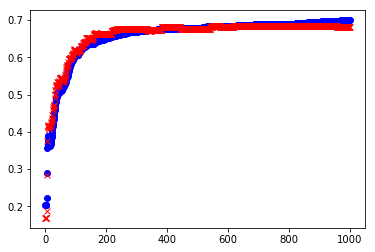

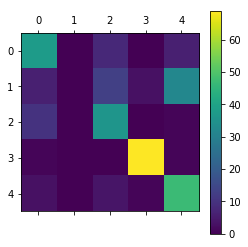

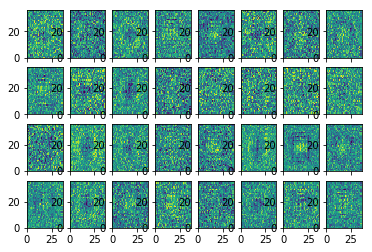

In [45]:
#2-2 single_hidden.py
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
#%autoindent

# Load data
data = np.load('/Users/Gene/Google Drive/UCI2016Winter/274C NRL NTWKS&DEEP LRNG Lec A /Project/Gene-Git/stock-prediction/Udemy-Tensorflow-Code/5582_04_Code/5582_04_02_Code/data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data

print(train[0])
print(labels[0])
print ("labels")
print (labels)
print "data"
print (data)

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.

    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
print("indices")
print (indices)
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

# Hidden layer
num_hidden = 128
W1 = tf.Variable(tf.truncated_normal([1296, num_hidden],
                                        stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)

# Output Layer
W2 = tf.Variable(tf.truncated_normal([num_hidden, 5],
                                        stddev=1./math.sqrt(5)))
b2 = tf.Variable(tf.constant(0.1,shape=[5]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h1,W2) + b2)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(y + 1e-20, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Actually train
epochs = 10000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()


# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x11ad3add0>> ignored
100%|##########| 25000/25000 [49:37<00:00,  8.95it/s]  


ValueError: Restore called with invalid save path mlp.ckpt

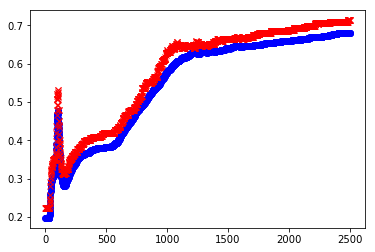

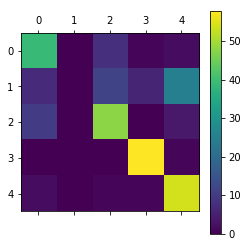

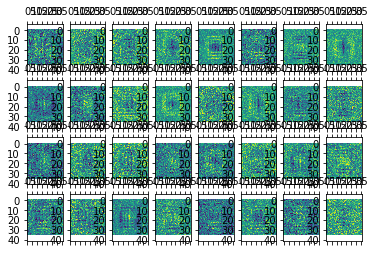

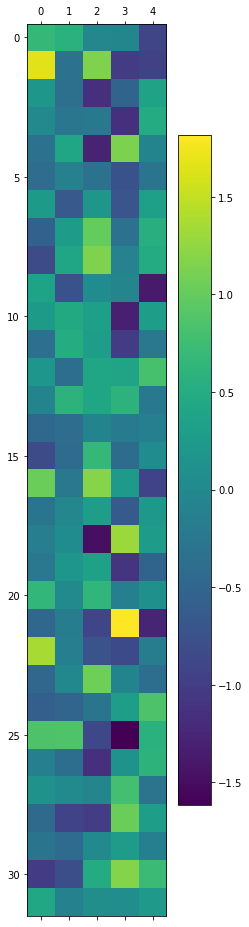

In [48]:
#2-4 Multiple Hidden layer
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
#%autoindent

# Load data
data = np.load('/Users/Gene/Google Drive/UCI2016Winter/274C NRL NTWKS&DEEP LRNG Lec A /Project/Gene-Git/stock-prediction/Udemy-Tensorflow-Code/5582_04_Code/5582_04_02_Code/data_with_labels.npz')
#data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.

    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx,training_idx=indices[:valid_cnt],indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

# Hidden layer 1
num_hidden1 = 128
W1 = tf.Variable(tf.truncated_normal([1296,num_hidden1],
                               stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden1]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)

# Hidden Layer 2
num_hidden2 = 32
W2 = tf.Variable(tf.truncated_normal([num_hidden1,
            num_hidden2],stddev=2./math.sqrt(num_hidden1)))
b2 = tf.Variable(tf.constant(0.2,shape=[num_hidden2]))
h2 = tf.sigmoid(tf.matmul(h1,W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal([num_hidden2, 5],
                                   stddev=1./math.sqrt(5)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h2,W3) + b3)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Actually train
epochs = 25000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].matshow(W1.eval()[:,i].reshape([36,36]))

# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

# Save the weights
saver = tf.train.Saver()
saver.save(sess, "mpl.ckpt")

# Restore
saver.restore(sess, "mlp.ckpt")




In [5]:
print(np.arange(6))


[0 1 2 3 4 5]


In [6]:
print(np.arange(12).reshape(4,3))

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]


In [22]:
b = np.array([[1,2,3,4,],[5,6,7,8],[9,10,11,12]])
print b.shape

(3, 4)


In [23]:
row_r1=b[0,:]
print row_r1.shape
print row_r1

(4,)
[1 2 3 4]


In [25]:
row_c1=b[:,0]
print row_c1.shape
print row_c1

(3,)
[1 5 9]


In [27]:
a=np.array([[[1,2,3,4,],[5,6,7,8],[9,10,11,12]]])
print a.shape

(1, 3, 4)


In [19]:
row_1=a[0,:,:]
print row_1.shape
print row_1

(3, 4)
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]


In [26]:
row_1=a[0,0,:]
print row_1.shape
print row_1

(4,)
[1 2 3 4]


In [30]:
row_1=a[0,:,0]
print row_1.shape
print row_1

(3,)
[1 5 9]


In [28]:
row_1=a[0,0,0]
print row_1.shape
print row_1

()
1


In [20]:
row_r1=a[:,0,:]
print row_r1.shape
print row_r1

(1, 4)
[[1 2 3 4]]


In [18]:
row_c1=a[:,:,0]
print row_c1.shape
print row_c1

(1, 3)
[[1 5 9]]
